In [1]:
#GraphSage

In [6]:
import stellargraph as sg
from stellargraph.mapper import CorruptedGenerator, FullBatchNodeGenerator
from stellargraph.layer import GCN, DeepGraphInfomax

import pandas as pd
from sklearn import model_selection, preprocessing
from IPython.display import display, HTML
import numpy as np

import tensorflow as tf
from tensorflow.keras import Model, layers, optimizers, callbacks

In [8]:
nodes = pd.read_csv("nodes.csv")
edges = pd.read_csv("edges.csv")

In [9]:
all_nodes = pd.DataFrame(np.unique(edges["from"].tolist()+edges["to"].tolist()+nodes["id"].tolist()),columns=["id"]).set_index("id").join(nodes.set_index("id"),how="outer")#.set_index('id')

In [10]:
labeled = nodes.set_index("id")

In [12]:
filteredfrom = edges[edges["from"].isin(labeled.index)]
filteredto = filteredfrom[filteredfrom["to"].isin(labeled.index)]

In [13]:
supervised = pd.DataFrame(np.unique(filteredto["from"].tolist()+filteredto["to"].tolist()+labeled.index.tolist()),columns=["id"]).set_index("id")

In [14]:
unsuper = pd.DataFrame(np.unique(edges["from"].tolist()+edges["to"].tolist()+nodes["id"].tolist()),columns=["id"]).set_index("id")

In [15]:
agg_edges = edges.groupby(["from","to"])["amount"].sum().reset_index()

In [16]:
agg_edges = agg_edges.rename(columns={"from":"source","to":"target","amount":"weight"})

In [17]:
G = sg.StellarDiGraph(nodes = unsuper,edges = agg_edges)

In [18]:
agg_filtered = filteredto.groupby(["from","to"])["amount"].sum().reset_index()

In [19]:
agg_filtered = agg_filtered.rename(columns={"from":"source","to":"target","amount":"weight"})

In [21]:
supervised = nodes.set_index('id')

In [46]:
G2 = sg.StellarDiGraph(nodes = supervised, edges = agg_filtered)

In [47]:
print(G2.info())

StellarDiGraph: Directed multigraph
 Nodes: 890, Edges: 85

 Node types:
  default: [890]
    Features: float32 vector, length 1
    Edge types: default-default->default

 Edge types:
    default-default->default: [85]
        Weights: range=[0.00721538, 3940.82], mean=282.609, std=719.537
        Features: none


In [49]:
generator = sg.mapper.PaddedGraphGenerator([G2])

In [50]:
fullbatch_generator = FullBatchNodeGenerator(G2)

corrupted_generator = CorruptedGenerator(fullbatch_generator)
gen = corrupted_generator.flow(G2.nodes())

Using GCN (local pooling) filters...


In [51]:
def make_gcn_model():
    # function because we want to create a second one with the same parameters later
    return GCN(
        layer_sizes=[16, 16],
        activations=["relu", "relu"],
        generator=fullbatch_generator,
        dropout=0.4,
    )


pretrained_gcn_model = make_gcn_model()

In [52]:
infomax = DeepGraphInfomax(pretrained_gcn_model, corrupted_generator)
x_in, x_out = infomax.in_out_tensors()

dgi_model = Model(inputs=x_in, outputs=x_out)
dgi_model.compile(
    loss=tf.nn.sigmoid_cross_entropy_with_logits, optimizer=optimizers.Adam(lr=1e-3)
)

In [53]:
epochs = 500


In [54]:
dgi_es = callbacks.EarlyStopping(monitor="loss", patience=50, restore_best_weights=True)
dgi_history = dgi_model.fit(gen, epochs=epochs, verbose=0, callbacks=[dgi_es])

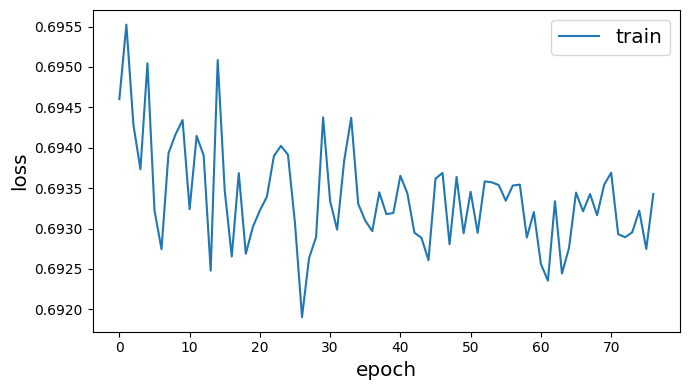

In [55]:
sg.utils.plot_history(dgi_history)


In [56]:
node_classes = nodes.set_index("id")["label"]

In [68]:
train_classes, test_classes = model_selection.train_test_split(
    node_classes, stratify=node_classes, random_state=42
)
val_classes, test_classes = model_selection.train_test_split(
    test_classes, stratify=test_classes
)

In [69]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_classes)
val_targets = target_encoding.transform(val_classes)
test_targets = target_encoding.transform(test_classes)

In [59]:
train_gen = fullbatch_generator.flow(train_classes.index, train_targets)
test_gen = fullbatch_generator.flow(test_classes.index, test_targets)
val_gen = fullbatch_generator.flow(val_classes.index, val_targets)

In [60]:
pretrained_x_in, pretrained_x_out = pretrained_gcn_model.in_out_tensors()

pretrained_predictions = tf.keras.layers.Dense(
    units=train_targets.shape[1], activation="softmax"
)(pretrained_x_out)

In [61]:
pretrained_model = Model(inputs=pretrained_x_in, outputs=pretrained_predictions)
pretrained_model.compile(
    optimizer=optimizers.Adam(lr=0.01), loss="categorical_crossentropy", metrics=["acc"],
)

In [62]:
prediction_es = callbacks.EarlyStopping(
    monitor="val_acc", patience=50, restore_best_weights=True
)

In [63]:
pretrained_history = pretrained_model.fit(
    train_gen,
    epochs=epochs,
    verbose=0,
    validation_data=val_gen,
    callbacks=[prediction_es],
)

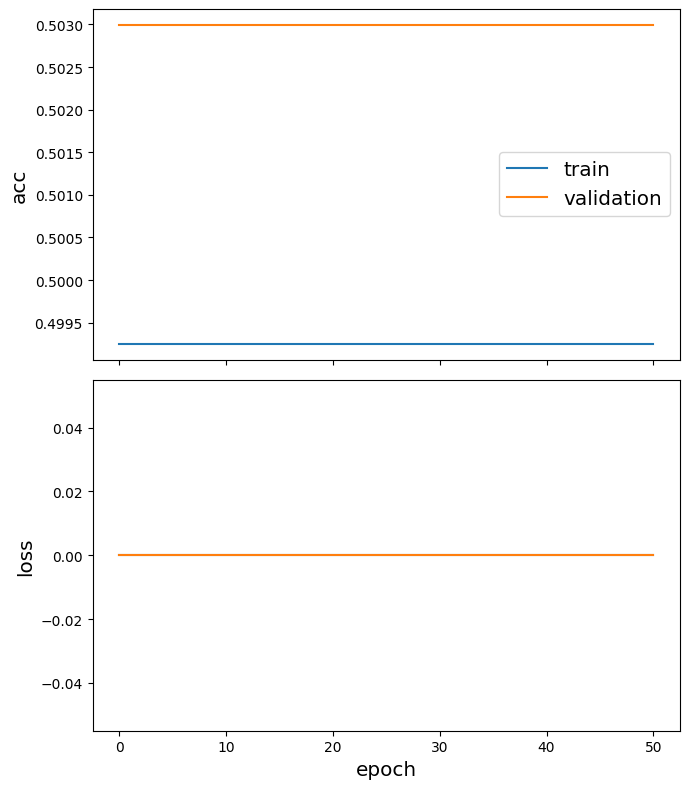

In [64]:
sg.utils.plot_history(pretrained_history)


In [65]:
pretrained_test_metrics = dict(
    zip(pretrained_model.metrics_names, pretrained_model.evaluate(test_gen))
)
print(pretrained_test_metrics)

1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - acc: 0.5000
{'loss': 0.0, 'acc': 0.5}


In [66]:
pd.DataFrame(
    [pretrained_test_metrics],
    index=["with DGI pre-training"],
).round(3)

,loss,acc
with DGI pre-training,0.0,0.5
